### Notes from FX intraday risk_premia ensemble strategy

Building Seasonality trades

* Main strategy is to go long foreign currency in a during home currency trading hours and short during off home country trading hours
* The determinants of the trading system are time of entry long and time of exitlong, entryshort

* Evaluate how the strategy works throughout the entire dataset
* How stable is it over time and across strategies
* Does it hold up in every year?
* Does it hold up for every asset?
* Use Information Ratio to determine per trade profitability: Measure of risk-adjusted return at the trade level
* Fundamental Law of Active Management by Grinold and Kahn
* For each pair, generate a backtest for each year and parameter combination
* Then take information ratio for each of the trades through time and across asset class and construct heat maps 
* On the x axis of the heat map will be the entry time in local time and the y-axis will be exit. 
* From these heat maps you'll be able to see what entry time and exit time led to highest IC
* We need to detrend the data to make sure we are not getting the trend alone
* Run the strategy for each local trading day currency: USD, EUR, JPY
* Identify detrended, best entry exit hours across time by pair
* If some of the pairs stand the test of time and give good entry exit times then you select those entries/exits
* Add those substrategies to your meta strategy and backtest each of the substrategies.

In [200]:
import pandas as pd
import numpy as np
import scipy
import xarray as xr
import dask 

import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns
matplotlib.rcParams['font.family'] = 'sans-serif'

matplotlib.rcParams['font.sans-serif'] = ['Tahoma', 'DejaVu Sans',
                               'Lucida Grande', 'Verdana']


* The code below constructs hourly mean returns for foreign currency during home currency business hours
* There is another function to plot hourly mean return by year
* It the plots to see what that effect looks like
* The first plot is simply without the year dimension and is just mean return across the whole dataset
* The second sequence of plots is the hourly mean cumulative return for a period of years to demonstrate how the effect is stable through time
* We do this for the EUR, JPY and USD as base currencies
* For each base currency there are different sets of foreign currencies

In [257]:
fx_data_path= '/Users/justinsimcock/Resilio Sync/FXBootcamp/Hourly/'

def fx_io_hourly(currency_pair, local_business_tz, fx_data_path=fx_data_path):
    '''
    Given a path and currency pair string opens csv file into pd.Dataframe
    Performs basic data manipulation like column assignment and datetime conversion
    
    Parameters
    ==========
    currency_pair: str in form `EURUSD`, `USDJPY`...
    local_business_tz: str in form EST, CET, Japan
    fx_data_path: str points to location of directory/file on local/remote disk
    
    Returns
    =======
    pd.Dataframe
    '''
    
    ts = pd.read_csv(fx_data_path + currency_pair + '.csv', 
                    header=None, 
                    names=['hour', 'open', 'high', 'low', 'close', 'volume'])
    ts = ts.reset_index().rename(columns={'index': 'date'})
    ts['date'] = ts['date'].astype(str)
    ts['date_time_utc'] = pd.to_datetime(ts['date']  + ' ' + ts['hour'], format='%Y%m%d %H:%M%S', utc=True)
    ts['date_time_{}'.format(local_business_tz)] = ts['date_time_utc'].dt.tz_convert(local_business_tz)
    #ts['return'] = ((ts.close - ts.close.shift(1))/ ts.close)
    
    return ts

def gen_seasonality_pairs(pair_string, local_time_zone, fx_data_path):
    '''
    Computes hourly mean return for a given currency pair, grouping by pandas hour datetime attr
    
    Parameters
    ----------
    currency_pair: str in form `EURUSD`, `USDJPY`...
    local_business_tz: str in form EST, CET, Japan
    fx_data_path: str points to location of directory/file on local/remote disk
    
    Returns
    -------
    pd.Series
    '''
    
    ts = fx_io_hourly(pair_string, local_time_zone, fx_data_path)
    ts['return'] = ((ts.close - ts.close.shift(1))/ ts.close)

    return ts.groupby(ts['date_time_{}'.format(local_time_zone)].dt.hour).mean()['return']

def hourly_return_by_year(pair, local_biz_tz, fx_data_path):
    '''
    Computes hourly mean return by year for a given currency pair, 
    grouping by pandas hour and year datetime attr
    
    Parameters
    ----------
    currency_pair: str in form `EURUSD`, `USDJPY`...
    local_business_tz: str in form EST, CET, Japan
    fx_data_path: str points to location of directory/file on local/remote disk
    
    Returns
    -------
    pd.MultiIndex
    
    '''
    pair = fx_io_hourly(pair, local_biz_tz, fx_data_path)
    pair['return'] = (pair.close - pair.close.shift(1))/ pair.close
    
    hourly_return_by_year = pair.groupby(
                                        [pair['date_time_{}'.format(local_biz_tz)].dt.hour, 
                                         pair['date_time_{}'.format(local_biz_tz)].dt.year]
                                        ).mean()['return']
    
    hourly_return_by_year.index.rename(['hour','year'], level=[0,1],inplace=True)
    
    
    return hourly_return_by_year

In [258]:
import glob
base = '/Users/justinsimcock/Resilio Sync/FXBootcamp/Hourly/'
euro_pairs_files = glob.glob(base + 'EUR*.csv')
jpy_pairs_files = glob.glob(base + '*JPY.csv')
usd_pairs_files = glob.glob(base + '*USD.csv') + glob.glob(base + 'USD*.csv')


In [248]:
usd_pair_files_foreign_base = glob.glob(base + 'USD*.csv')

In [230]:
euro_pairs = [s.split('/')[-1].split('.')[0] for s in euro_pairs_files]
#remove EURRUB
# euro_pairs = [s for s in euro_pairs if s != 'EURRUB']

#### Plot hourly returns for all pairs 

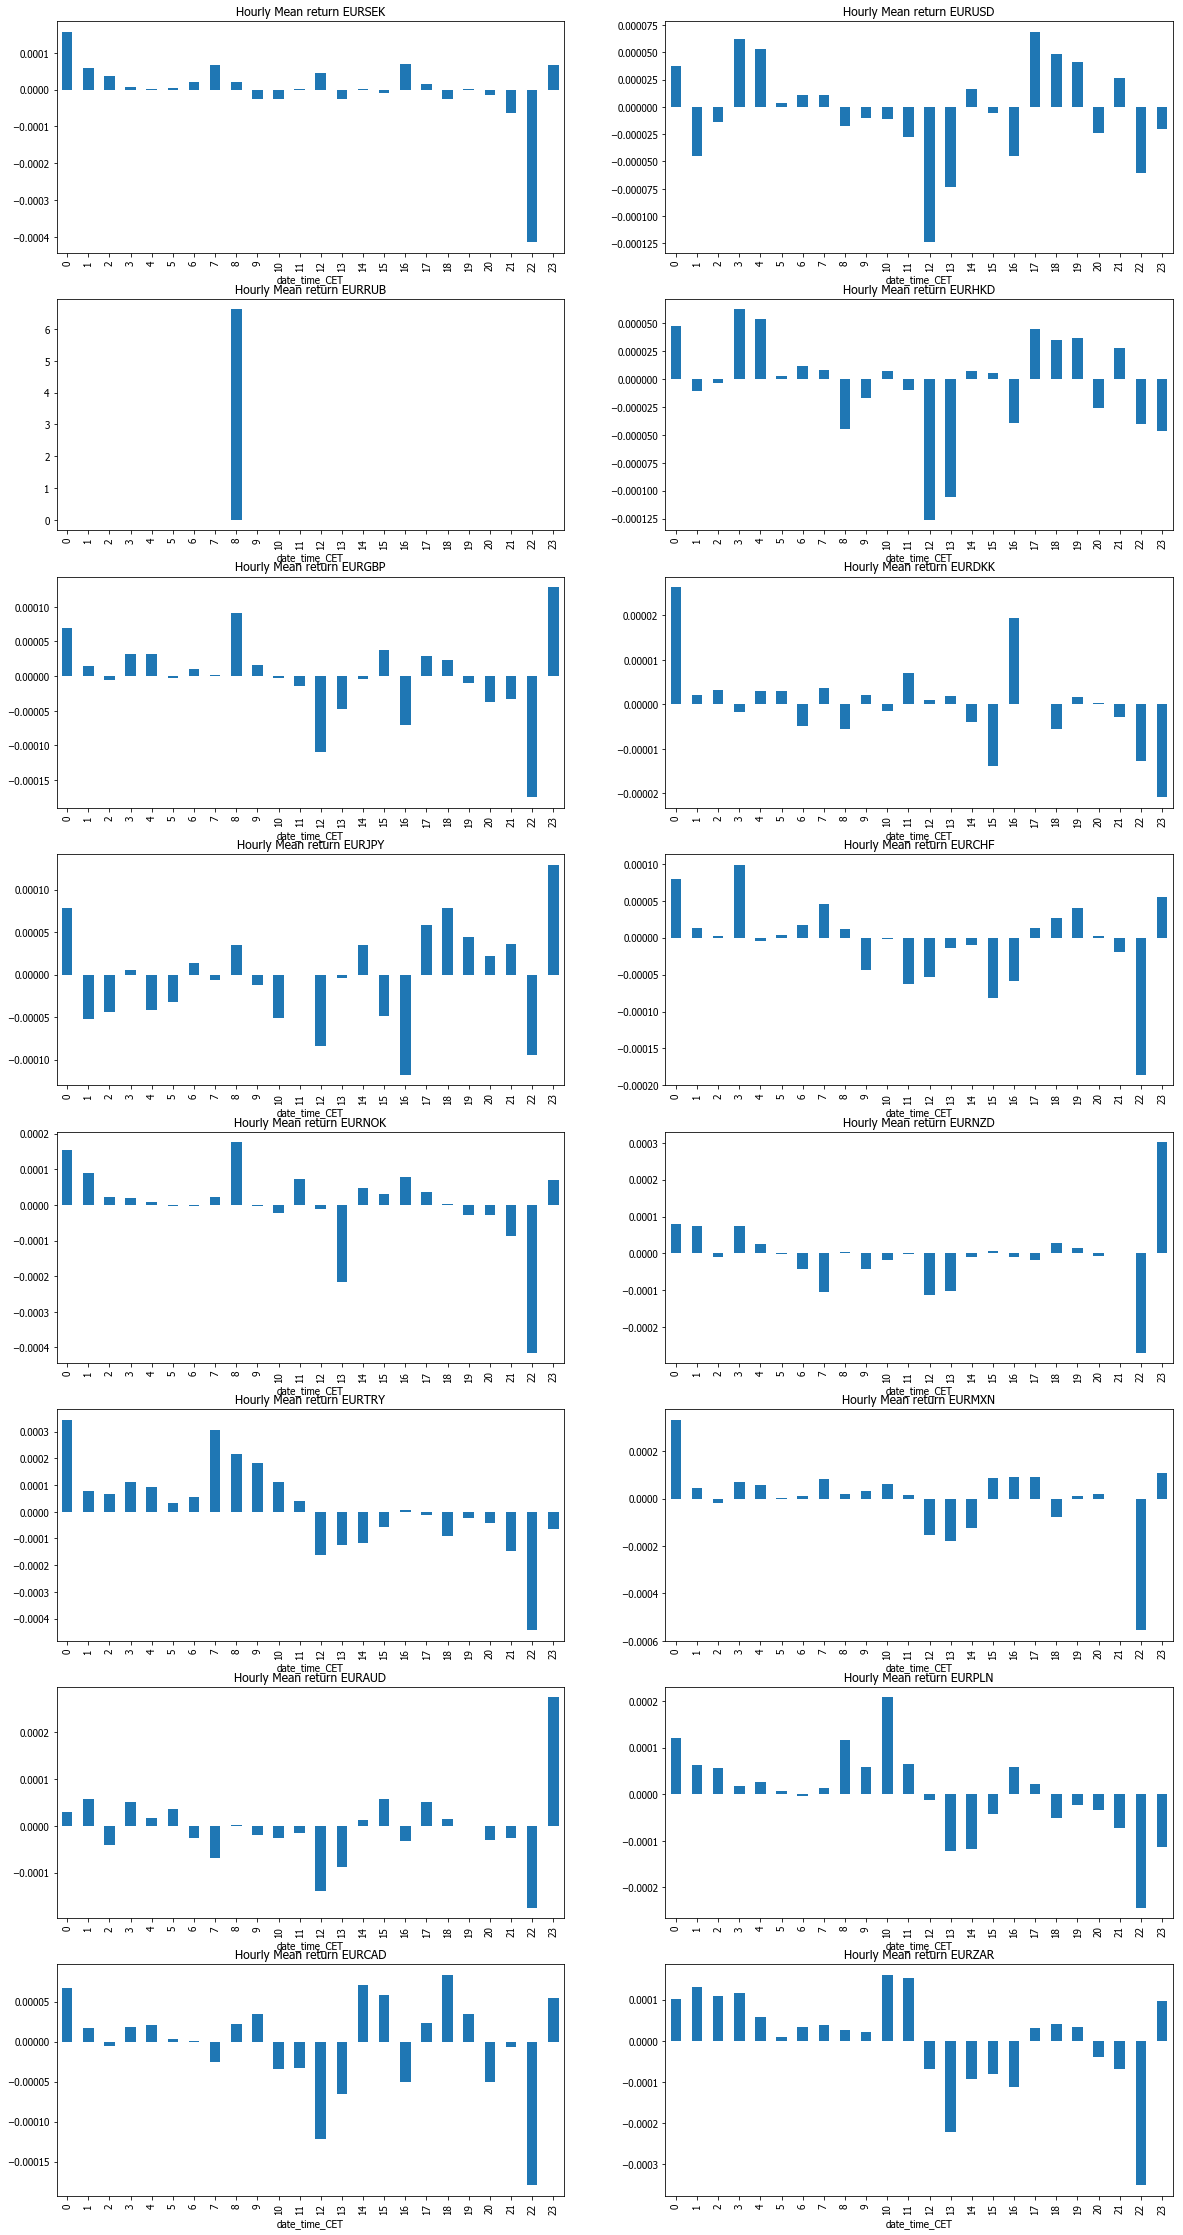

In [232]:

fig, ax = plt.subplots(nrows=8, ncols=2, figsize=(20,40), sharex=False)

for i, pair in enumerate(euro_pairs):
    axes = gen_seasonality_pairs(pair, 'CET', fx_data_path)
    axes.plot(kind='bar', ax=ax[i//2, i%2], label= 'Hourly Mean return {}'.format(pair))
    ax[i//2, i%2].set_title('Hourly Mean return {}'.format(pair))

#### EURRUB  looks a bit weird

In [236]:
EUR_RUB = fx_io_hourly('EURRUB', 'CET', fx_data_path)
EUR_RUB['return'] = ((EUR_RUB.close - EUR_RUB.close.shift(1))/ EUR_RUB.close)
EUR_RUB['return'].max()

11346.8

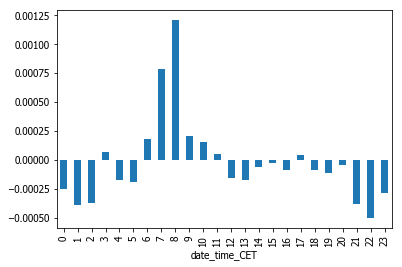

In [237]:
EUR_RUB.loc[EUR_RUB['return'] < 1].groupby(EUR_RUB['date_time_CET'].dt.hour).mean()['return'].plot(kind='bar')

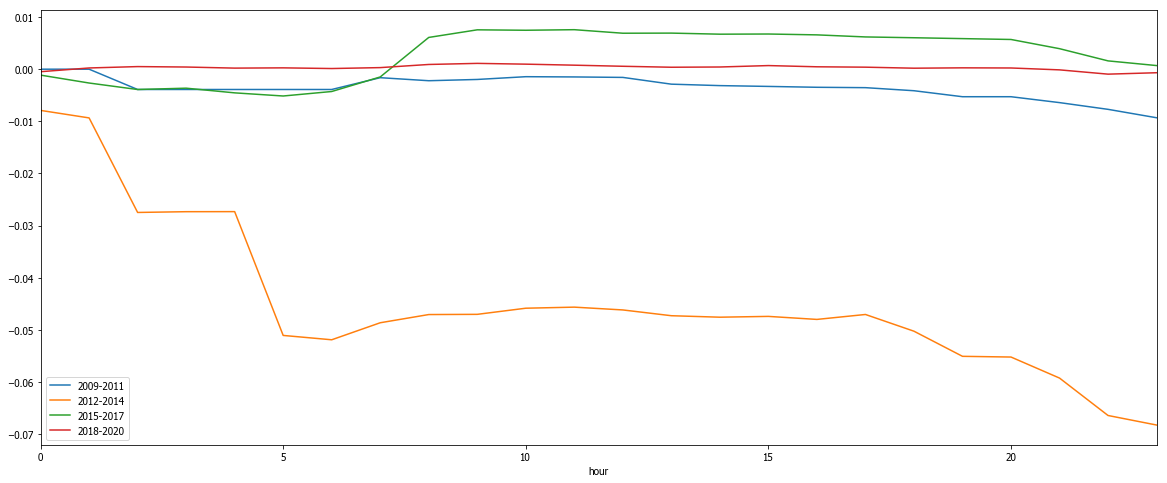

In [238]:
#Let's look at different periods of time to see if this holds up through time
hourly_return_by_year_EURRUB = EUR_RUB.loc[EUR_RUB['return'] < 1].groupby([EUR_RUB['date_time_CET'].dt.hour, EUR_RUB['date_time_CET'].dt.year]).mean()['return']
# hourly_return_by_year.unstack(level=1).plot(kind='line', figsize=(20,10));
hourly_return_by_year_EURRUB.index.rename(['hour','year'], level=[0,1],inplace=True)



fig, ax = plt.subplots(figsize=(20,8), sharex=False)

for i in range(1, 11,3):
    axes = hourly_return_by_year_EURRUB.loc[:,2006+i:2009 + i].groupby(level=0
                                                               ).sum().cumsum(
                                                                ).plot(
                                                                label="{}-{}".format(2008+i, 2010+i), 
                                                                legend=True)

In [213]:
hourly_by_year_eursek = hourly_return_by_year('EURSEK', 'CET', fx_data_path)

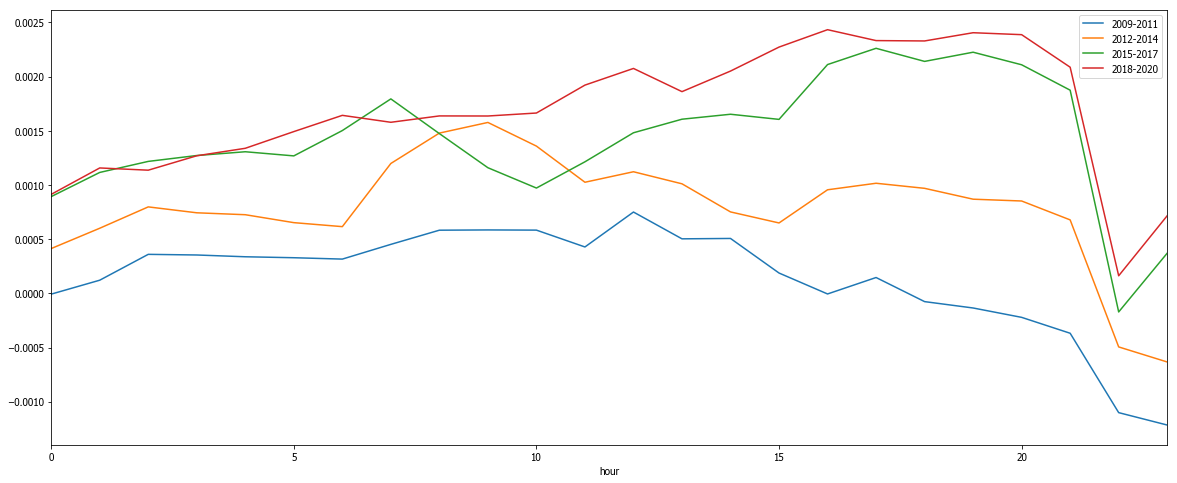

In [215]:

fig, ax = plt.subplots(figsize=(20,8), sharex=False)

for i in range(1, 11,3):
    axes = hourly_by_year_eursek.loc[:,2006+i:2009 + i].groupby(level=0
                                                               ).sum().cumsum(
                                                                ).plot(
                                                                label="{}-{}".format(2008+i, 2010+i), 
                                                                legend=True)
 


#### Let's break the hourly returns into 2-3 year periods and see how it looks through time


* We'll do Euro First
* We want to know if the effect is consistent 



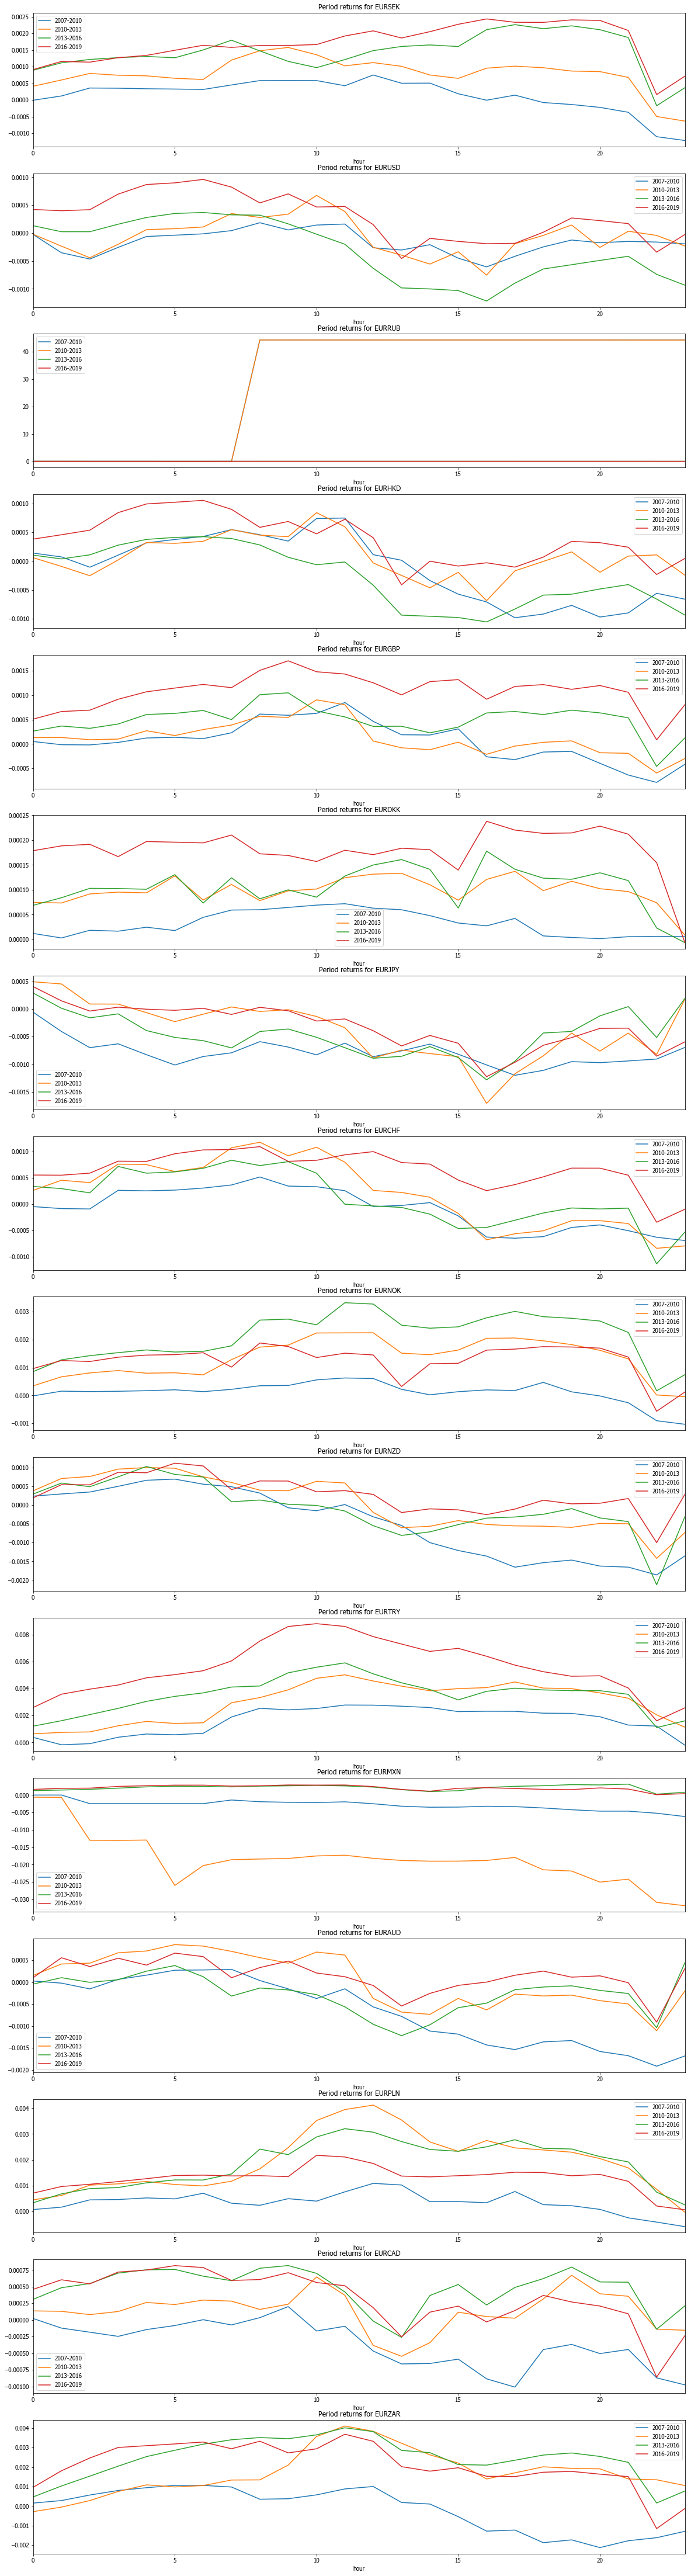

In [241]:
fig, ax = plt.subplots(nrows=16,figsize=(20,80), sharex=False)

for j, pair in enumerate(euro_pairs):
    for i in range(1, 11,3):
        axes = hourly_return_by_year(pair, 'CET', fx_data_path).loc[:,2006+i:2009 + i].groupby(level=0
                                                                   ).sum().cumsum()
        axes.plot(ax=ax[j], legend=True, label="{}-{}".format(2006+i, 2009+i))

        ax[j].set_title('Period returns for {}'.format(pair))
        
 


In [ ]:
### Now we'll do JPY

In [218]:
jpy_pairs = [s.split('/')[-1].split('.')[0] for s in jpy_pairs_files]

In [219]:
len(jpy_pairs)

7

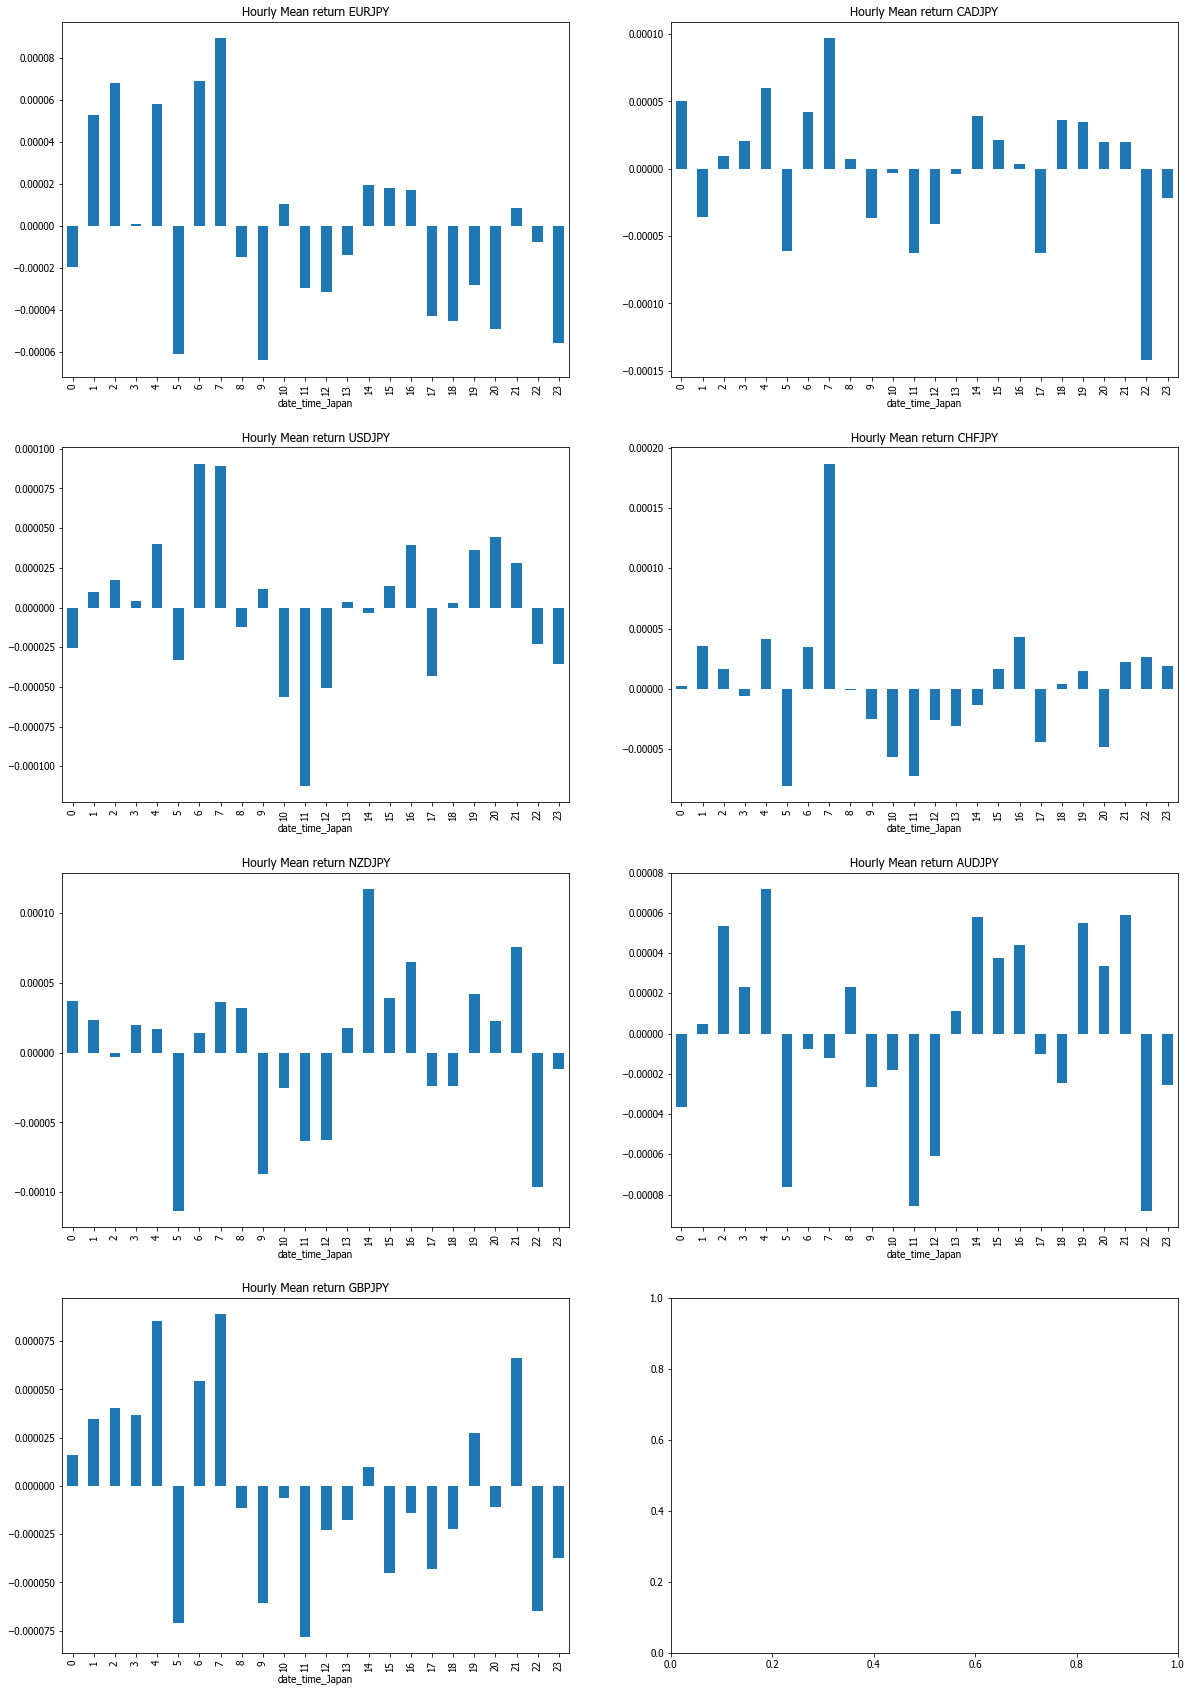

In [220]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(20,30), sharex=False)

for i, pair in enumerate(jpy_pairs):
    axes = gen_seasonality_pairs(pair, 'Japan', fx_data_path)
    axes.plot(kind='bar', ax=ax[i//2, i%2], label= 'Hourly Mean return {}'.format(pair))
    ax[i//2, i%2].set_title('Hourly Mean return {}'.format(pair))

### Now let's have a look at the cumulative returns throughout the day by year periods

* It looks like the effect is consistent through time
* We do see similar behavior between the NZD and AUD
* We also see similar behavior between the European and North American currencies

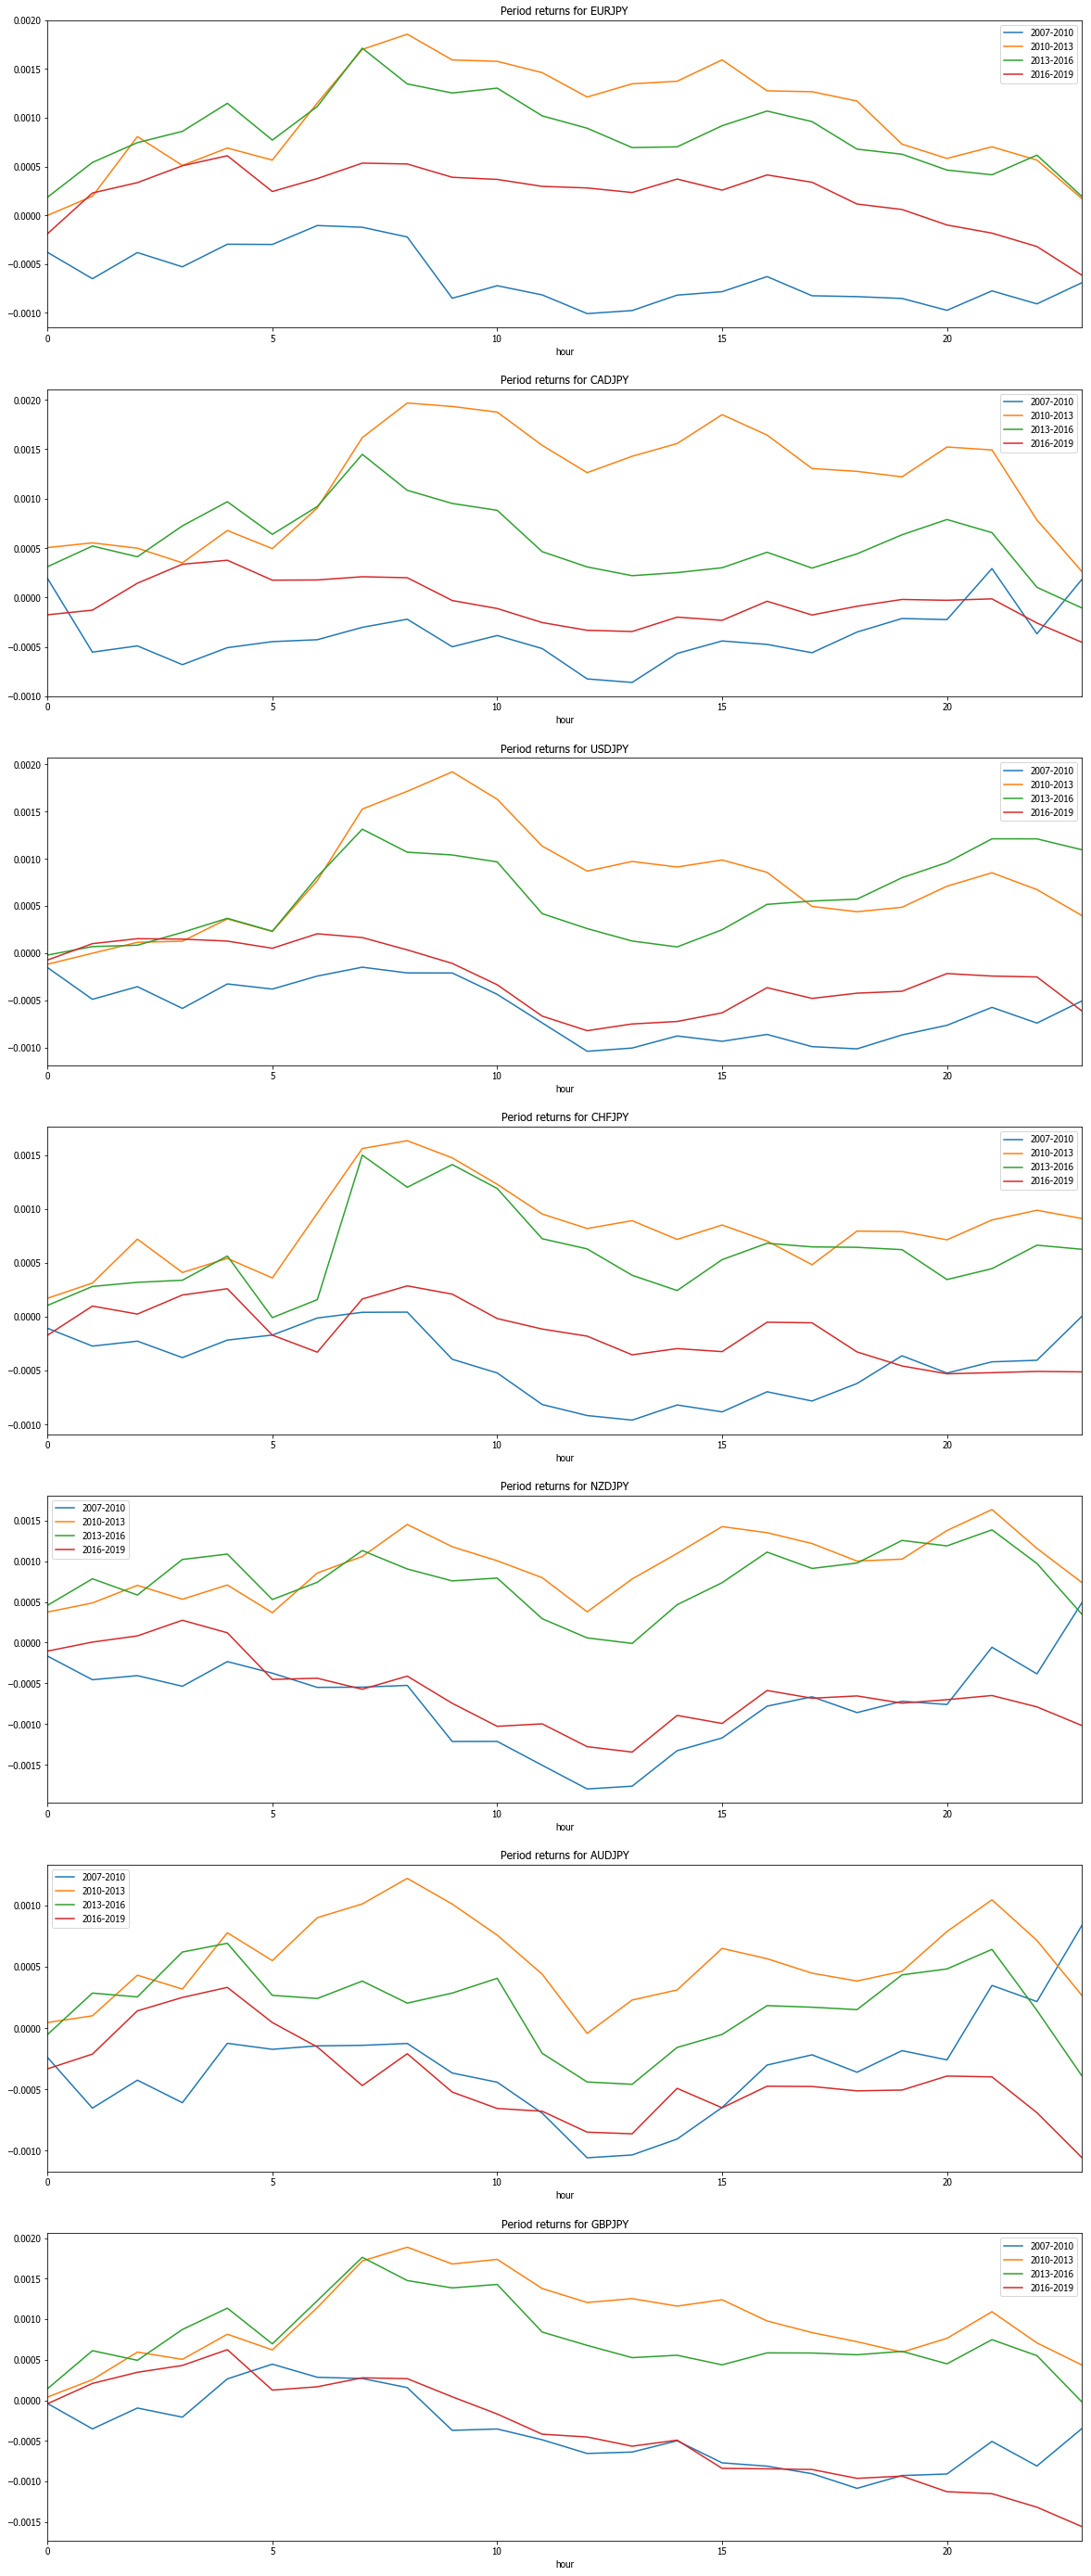

In [226]:
fig, ax = plt.subplots(nrows=7,figsize=(20,50), sharex=False)

for j, pair in enumerate(jpy_pairs):
    for i in range(1, 11,3):
        axes = hourly_return_by_year(pair, 'Japan', fx_data_path).loc[:,2006+i:2009 + i].groupby(level=0
                                                                   ).sum().cumsum()
        axes.plot(ax=ax[j], legend=True, label="{}-{}".format(2006+i, 2009+i))
        ax[j].set_title('Period returns for {}'.format(pair))
        
 


In [250]:
usd_pair_files_foreign_base
usd_pairs_foreign_base = [s.split('/')[-1].split('.')[0] for s in usd_pair_files_foreign_base]

In [268]:
pair = fx_io_hourly(usd_pairs_foreign_base[-2], 'EST', fx_data_path)
# pair['close'] = 1/pair.close

In [271]:
len(usd_pair_files_foreign_base)

12

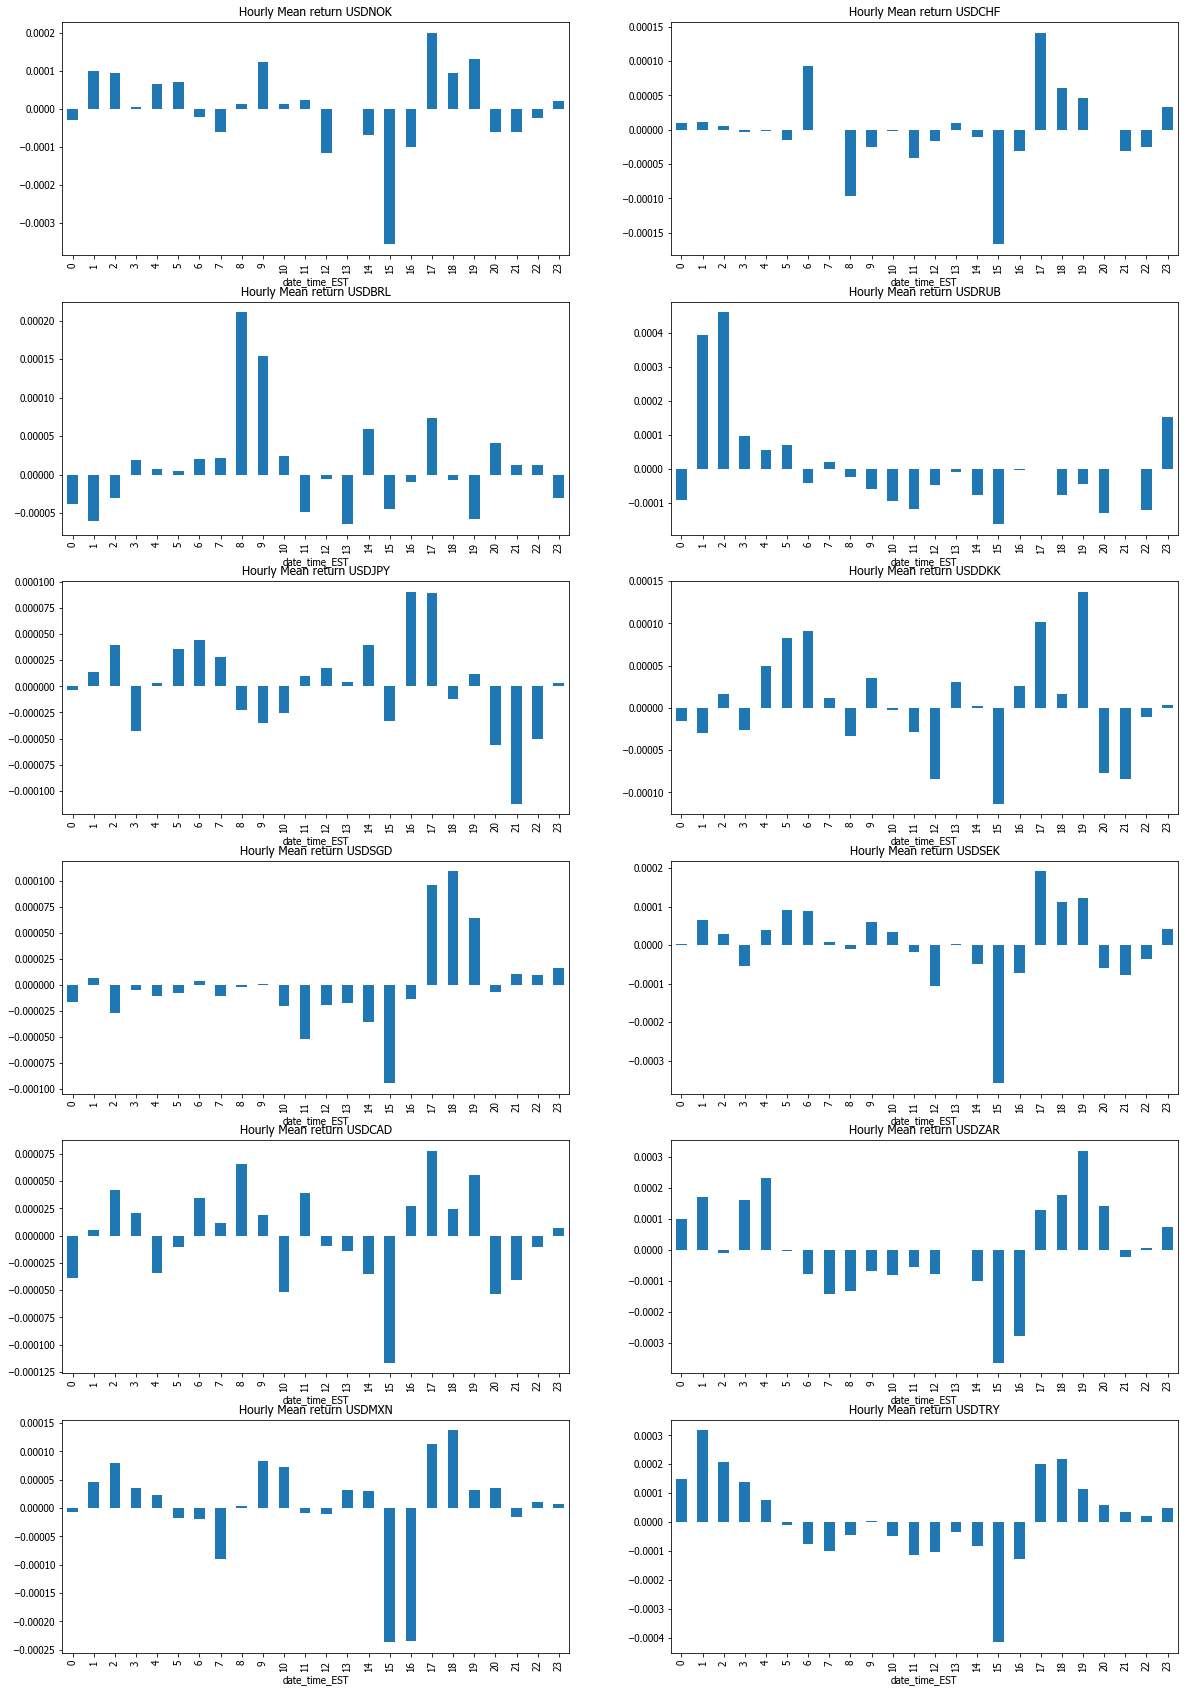

In [272]:
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(20,30), sharex=False)

for i, pair in enumerate(usd_pairs_foreign_base):
    axes = gen_seasonality_pairs(pair, 'EST', fx_data_path)
    axes.plot(kind='bar', ax=ax[i//2, i%2], label= 'Hourly Mean return {}'.format(pair))
    ax[i//2, i%2].set_title('Hourly Mean return {}'.format(pair))

### Drop the Kroner since it is missing data

In [294]:
usd_pairs_no_dkk = [p for p in usd_pairs if p != 'USDDKK']

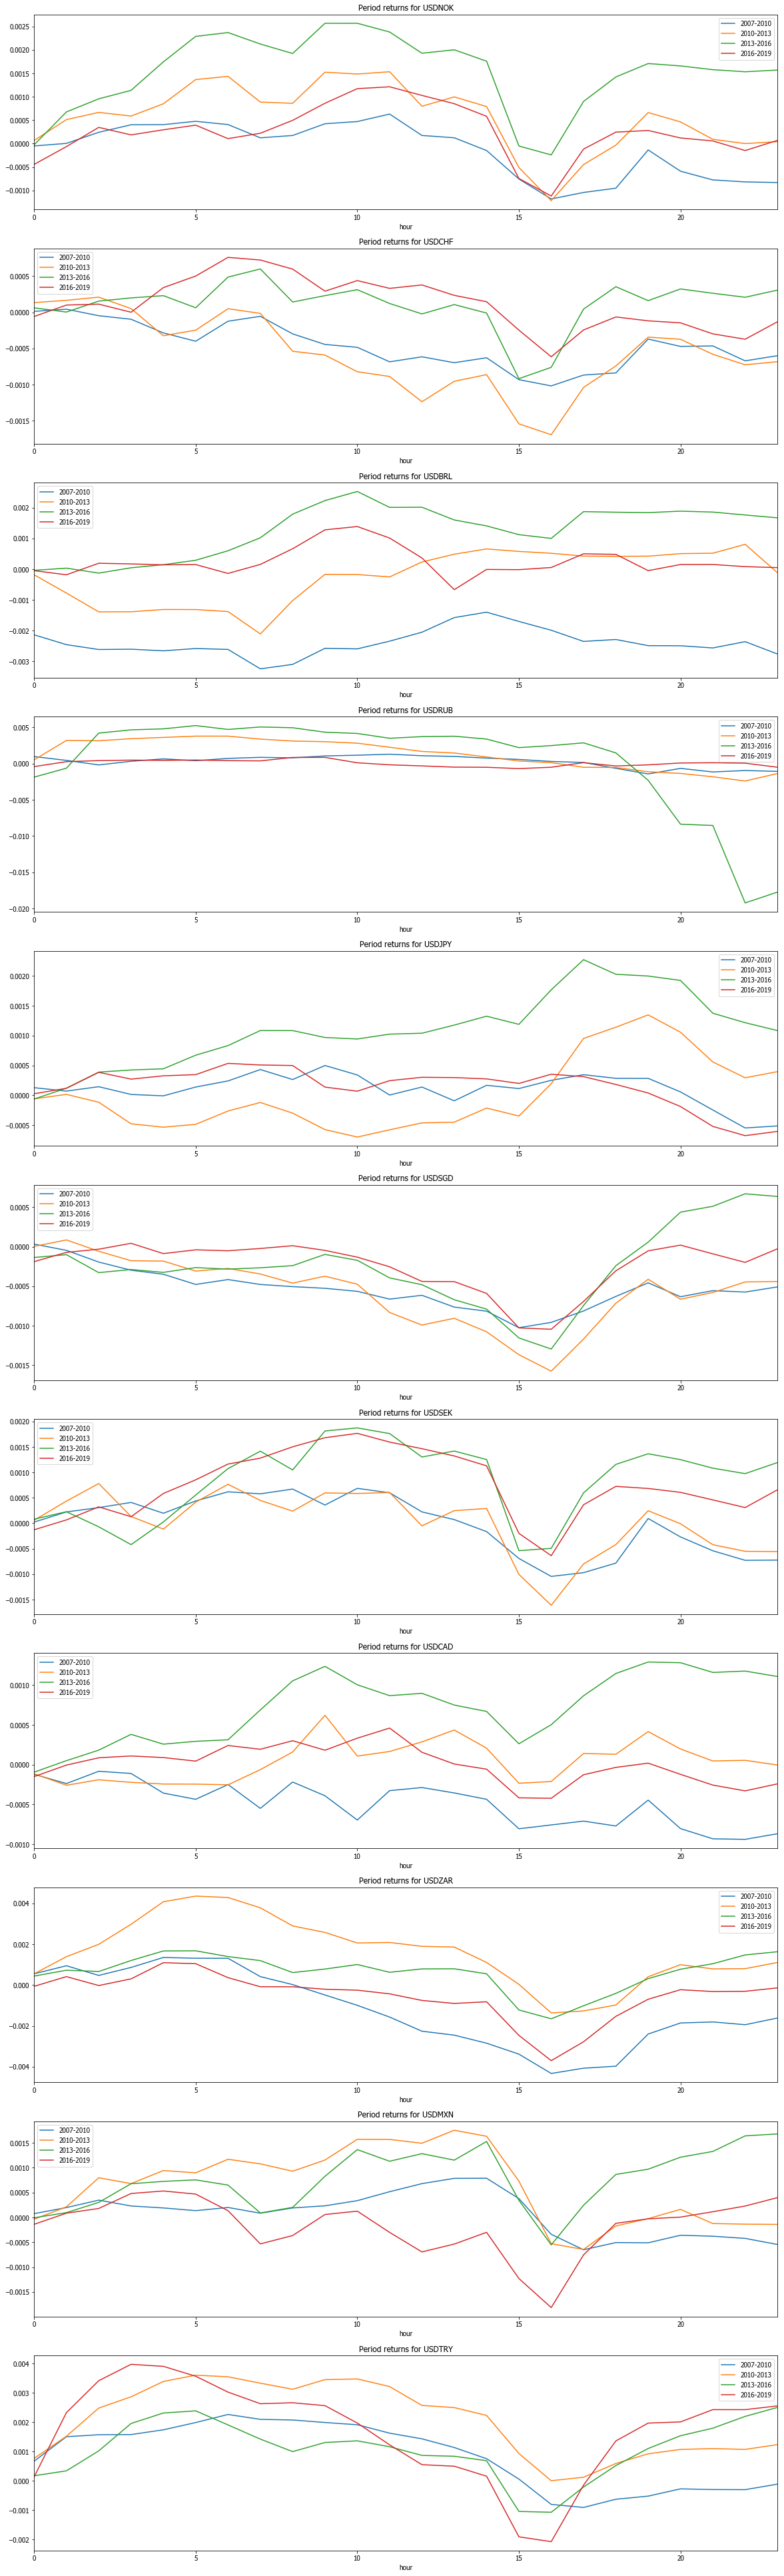

In [297]:
fig, ax = plt.subplots(nrows=11,figsize=(20,70), sharex=False)

for j, pair in enumerate(usd_pairs_no_dkk):
    for i in range(1, 11,3):
        axes = hourly_return_by_year(pair, 'EST', fx_data_path).loc[:,2006+i:2009 + i].groupby(level=0
                                                                   ).sum().cumsum()
        axes.plot(ax=ax[j], legend=True, label="{}-{}".format(2006+i, 2009+i))
        ax[j].set_title('Period returns for {}'.format(pair))
        
 
